# Libraries

In [2]:
!pip install -q gdown

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gdown
import numpy as np
from scipy.sparse import csr_matrix, vstack  # Thêm dòng này để tránh lỗi
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Input Data

In [5]:
file_id = "1uCfCvbOW2c3Sc0AgJ7V_YnLoC3Nya19y"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "job.npy", quiet=False)


candidate_file_id = "1_8DI8zpGb456GBDnvB5CFEnPu-Z1hsF6"
gdown.download(f"https://drive.google.com/uc?id={candidate_file_id}", "candidate.npy", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uCfCvbOW2c3Sc0AgJ7V_YnLoC3Nya19y
To: /content/job.npy
100%|██████████| 8.74M/8.74M [00:00<00:00, 48.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_8DI8zpGb456GBDnvB5CFEnPu-Z1hsF6
To: /content/candidate.npy
100%|██████████| 18.0M/18.0M [00:00<00:00, 81.7MB/s]


'candidate.npy'

# Data job and candidate

In [6]:
data_job = np.load("job.npy", allow_pickle=True)

# Check if the loaded data is a 0-dimensional array containing a sparse matrix
if isinstance(data_job, np.ndarray) and data_job.ndim == 0 and isinstance(data_job.item(), csr_matrix):
    data_job = data_job.item()  # Extract the sparse matrix from the 0-dimensional array

print(data_job.shape)
print(data_job)


(21858, 100)
[[-0.04842205  0.07093979  0.03057086 ... -0.11030681  0.02673039
  -0.06701973]
 [-0.04854496  0.06176482  0.02691649 ... -0.08846921  0.02645277
  -0.03582477]
 [-0.03061208  0.06721358  0.0365071  ... -0.0972569   0.01788957
  -0.06573646]
 ...
 [-0.03685275  0.06403032  0.03598811 ... -0.11301722  0.04871529
  -0.04244052]
 [-0.03868866  0.06345186  0.04983663 ... -0.10024206  0.02628342
  -0.04441851]
 [-0.01982653  0.06791665  0.04795274 ... -0.10211765  0.04519879
  -0.05872609]]


In [7]:
data_candidate = np.load("candidate.npy", allow_pickle=True)  # thêm allow_pickle nếu bị lỗi

# Check if the loaded data is a 0-dimensional array containing a sparse matrix
if isinstance(data_candidate, np.ndarray) and data_candidate.ndim == 0 and isinstance(data_candidate.item(), csr_matrix):
    data_candidate = data_candidate.item() # Extract the sparse matrix from the 0-dimensional array

print(data_candidate.shape)
print(data_candidate)

(44963, 100)
[[-0.07482756  0.03886157 -0.00630915 ... -0.06931121  0.00931517
  -0.06601292]
 [-0.03019178  0.0455108  -0.04454535 ... -0.04696453  0.02811295
  -0.07133038]
 [-0.01433718  0.04510158  0.00720376 ... -0.00435975 -0.00366204
  -0.00214432]
 ...
 [ 0.00035721  0.06102966  0.02315904 ... -0.06363477  0.01763997
  -0.05302427]
 [-0.0473704   0.03478713  0.0103186  ... -0.02186246  0.00774201
  -0.00512074]
 [-0.04503294  0.09686724 -0.05587948 ... -0.1095858   0.03685639
  -0.05471559]]


# Process batch

In [8]:
batch_size = 1000
num_candidates = data_candidate.shape[0]
num_jobs = data_job.shape[0]

# Step 1: Initialize the similarity matrix
similarity_matrix_pho2vec = np.zeros((num_candidates, num_jobs), dtype=np.float32)

In [9]:
# Step 2: Process in batches
for i in tqdm(range(0, num_candidates, batch_size), desc="🚀 Calculating PhoBERT Similarities"):
    candidate_batch = data_candidate[i:i + batch_size]

    batch_similarity = cosine_similarity(candidate_batch, data_job)

    # Corrected line using the right variable name
    similarity_matrix_pho2vec[i:i + batch_similarity.shape[0]] = batch_similarity

🚀 Calculating PhoBERT Similarities: 100%|██████████| 45/45 [00:10<00:00,  4.16it/s]


In [10]:
df_candidate = pd.read_csv("/content/drive/Shareddrives/PTDL WEB/PTDL WEB - FINAL/Dataset/Feature Engineering Data/processed_candidate.csv")
df_candidate.drop("Unnamed: 0", axis=1, inplace=True)
display(df_candidate.head())
df_job= pd.read_csv("/content/drive/Shareddrives/PTDL WEB/PTDL WEB - FINAL/Dataset/Feature Engineering Data/df_job_processed.csv")
display(df_job.head())

,user_url,userid,user_name,industry,workplace_desired,desired_salary,gender,marriage,age,work_experience,desired_job_translated,proc_desired_job,proc_industry,proc_workplace
0,https://timviec365.vn/uvtv2/dao-huu-tai-uv1111...,1111684868,Đào Hữu Tài,Kd Bất Động Sản,Hà Nội,Thỏa Thuận,Nam,Độc Thân,38.0,Dưới 1 năm,Chuyên Viên Kinh Doanh Bất Động Sản,chuyên_viên kinh_doanh bất_động_sản,kd bất_động_sản,h_nội
1,https://timviec365.vn/uvtv2/ho-vinh-duc-uv199803,199803,Hồ Vĩnh Đức,Xây Dựng,Hồ Chí Minh,Thỏa Thuận,Nam,Khác,37.0,Không yêu cầu kinh nghiệm,Kỹ Sư Kinh Tế Xây Dựng,kỹ_sư kinh_tế y_dựng,y_dựng,hồ chí minh
2,https://timviec365.vn/uvtv2/ngo-thi-bich-tram-...,1271594,Ngô Thị Bích Trâm,Khách Sạn - Nhà Hàng,Khánh Hòa,Thỏa Thuận,Nam,Độc Thân,NaN,Chưa Có Kinh Nghiệm,Nhân Viên Nhà Hàng,nh viên nh h_ng,khách_sạn nh h_ng,khánh_hòa
3,https://timviec365.vn/uvtv2/vo-ba-loi-uv160413,160413,Võ Bá Lợi,Giao Thông Vận Tải - Thủy Lợi - Cầu Đường,Hồ Chí Minh,Thỏa Thuận,Nam,Độc Thân,NaN,Chưa Có Kinh Nghiệm,Đầu Bếp,đầu_bếp,giao_thông vận_tải thủy_lợi cầu_đường,hồ chí minh
4,https://timviec365.vn/uvtv2/vo-thi-thuy-van-uv...,1111646039,Võ Thị Thuỳ Vân,Quản Trị Kinh Doanh,Đồng Nai,Thỏa Thuận,Nữ,Độc Thân,21.0,Chưa Có Kinh Nghiệm,Thực Tập Sinh Kinh Doanh,thực_tập_sinh kinh_doanh,quản_trị kinh_doanh,đồng_nai


,Job_Name,Company_name,Location,Salary,Time,Benefit,Description,Requirement,URL,Industry,Type,Requirement_processed,Type_processed,Description_processed,Industry_processed
0,Chuyên Viên Hỗ Trợ Kỹ Thuật ( ô tô thương mại)...,CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,Cạnh tranh,10/31/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...",• Hỗ trợ kỹ thuật & hướng dẫn sửa chữa cho hệ ...,• Tốt nghiệp đại học ngành Cơ khí ô tô. • Tối ...,https://careerviet.vn/vi/tim-viec-lam/chuyen-v...,Cơ khí / Ô tô / Tự động hóa,Nhân viên chính thức,tốt_nghiệp đại_học ng nh cơ_khí ô_tô tối_thiểu...,nh n viên chính_thức,hỗ_trợ kỹ_thuật hướng_dẫn sửa_chữa hệ_thống đạ...,cơ_khí ô_tô tự_động_hóa
1,CHUYÊN VIÊN PHỤ TÙNG (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hồ Chí Minh,"5,000,000 - 10,000,000",9/30/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...","- Xây dựng chính sách, kế hoạch và KPI kinh do...","-Tốt nghiệp ĐH ngành Cơ khí ô tô, Logistics, K...",https://careerviet.vn/vi/tim-viec-lam/chuyen-v...,Tiếp thị / Marketing,Nhân viên chính thức,tốt_nghiệp đh ng nh cơ_khí ô_tô logistics kinh...,nh n viên chính_thức,x y dựng chính_sách kế_hoạch v kpi kinh_doanh ...,tiếp_thị marketing
2,PHÓ TRƯỞNG BỘ PHẬN PHÁP LÝ – ĐĂNG KIỂM XE CBU/...,CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,Cạnh tranh,8/31/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...",Mô tả công việc: - Quản lý hồ sơ pháp lý – kỹ ...,"- Tốt nghiệp kỹ thuật ô tô, cơ khí, luật hoặc ...",https://careerviet.vn/vi/tim-viec-lam/pho-truo...,Luật / Pháp lý,Nhân viên chính thức,tốt_nghiệp kỹ_thuật ô_tô cơ_khí luật liên_quan...,nh n viên chính_thức,mô_tả công_việc quản_lý hồ_sơ pháp_lý kỹ_thuật...,luật pháp_lý
3,Tài Xế Lái Xe Cho Giám Đốc (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hồ Chí Minh,"5,000,000 - 10,000,000",6/30/2025,"Chế độ bảo hiểm, Du Lịch, Đồng phục, Chế độ th...","Mô tả công việc Phụ trách đưa đón, chuyên chở ...","Nam, sức khỏe tốt, không bị cận; GPLX hạng B2 ...",https://careerviet.vn/vi/tim-viec-lam/tai-xe-l...,Vận chuyển / Giao nhận / Kho vận,Nhân viên chính thức,nam sức_khỏe tốt cận gplx hạng b2 trở lên sẵn ...,nh n viên chính_thức,mô_tả công_việc phụ_trách đưa_đón chuyên_chở l...,vận_chuyển_giao_nhận kho vận
4,Phiên dịch viên tiếng Trung Quốc (MỚI),CÔNG TY CP TM DV AN SƯƠNG,Hà Nội,"15,000,000 - 20,000,000",8/31/2025,"Chế độ bảo hiểm, Du Lịch, Chế độ thưởng, Chăm ...","- Phiên dịch, biên dịch tài liệu kỹ thuật và n...",- Thành thạo tiếng Trung - Ưu tiên ứng viên có...,https://careerviet.vn/vi/tim-viec-lam/phien-di...,Hành chính / Thư ký,Nhân viên chính thức,th nh thạo tiếng trung ưu_tiên ứng_viên kinh_n...,nh n viên chính_thức,phiên_dịch biên_dịch t_i liệu kỹ_thuật v nội_d...,h nh chính thư_ký


# Save final file

In [11]:
top_k_pool_size = 10 # How many recommendations to generate from each model

rows = []
for candidate_id in range(num_candidates):
    # Use the PhoBERT similarity matrix
    candidate_scores = similarity_matrix_pho2vec[candidate_id]
    top_indices = np.argsort(-candidate_scores)[:top_k_pool_size]

    for rank in range(len(top_indices)):
        job_id = top_indices[rank]
        score = candidate_scores[job_id]
        rows.append({
            "candidate_id": candidate_id,
            "job_id": job_id,
            "similarity_score": score,
            "rank": rank + 1
        })

df_phobert_recs = pd.DataFrame(rows)

In [12]:
# ========= CONFIG ========= #
top_k_job2job = 5
top_k_similar_jobs = []

for i in tqdm(range(data_job.shape[0]), desc="🔁 Computing job-to-job"):
    # ✅ Ensure 2D shape with i:i+1
    sim_scores = cosine_similarity(data_job[i:i+1], data_job).flatten()
    sim_scores[i] = -1  # exclude self

    top_indices = np.argpartition(sim_scores, -top_k_job2job)[-top_k_job2job:]
    top_scores = sim_scores[top_indices]
    sorted_top_k = sorted(zip(top_indices, top_scores), key=lambda x: x[1], reverse=True)

    for rank, (j_idx, score) in enumerate(sorted_top_k):
        top_k_similar_jobs.append({
            'source_job_id': i,
            'expanded_job_id': j_idx,
            'similarity_score_job2job': float(score),
            'job2job_rank': rank + 1
        })

job_to_job_df = pd.DataFrame(top_k_similar_jobs)

# ========= MERGE TO EXPAND CANDIDATE JOB LIST ========= #
# Note: df has candidate_id, job_id, similarity_score, rank

expanded_df = df_phobert_recs.merge(
    job_to_job_df,
    how='left',
    left_on='job_id',
    right_on='source_job_id'
)

expanded_df['hybrid_score'] = (
    0.7 * expanded_df['similarity_score'] +
    0.3 * expanded_df['similarity_score_job2job']
)

# Drop missing expanded jobs and deduplicate
expanded_df = expanded_df.dropna(subset=['expanded_job_id'])
expanded_df = expanded_df.sort_values(
    by=['candidate_id', 'expanded_job_id', 'hybrid_score'],
    ascending=[True, True, False]
).drop_duplicates(subset=['candidate_id', 'expanded_job_id'])

# Preview
expanded_df.head()

🔁 Computing job-to-job: 100%|██████████| 21858/21858 [04:22<00:00, 83.31it/s] 


,candidate_id,job_id,similarity_score,rank,source_job_id,expanded_job_id,similarity_score_job2job,job2job_rank,hybrid_score
9,0,14885,0.822275,2,14885,1063,0.821247,5,0.821967
3,0,10031,0.824300,1,10031,1396,0.948080,4,0.861434
38,0,15262,0.811046,8,15262,2388,0.877037,4,0.830844
40,0,18950,0.801772,9,18950,6100,0.964204,1,0.850502
41,0,18950,0.801772,9,18950,8260,0.964204,2,0.850502


# **Add Heuristic-Based Ground Truth**


In [13]:
def normalize_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r"[^\w\s]", "", text.lower().strip())

def parse_numeric_value(value_str):
    if pd.isna(value_str):
        return None
    cleaned_str = re.sub(r"[^\d\-\.]", "", str(value_str))
    if "-" in cleaned_str:
        try:
            parts = cleaned_str.split("-")
            if len(parts) == 2:
                return (float(parts[0]) + float(parts[1])) / 2
            elif len(parts) == 1 and cleaned_str.startswith('-'):
                return float(cleaned_str)
            elif len(parts) == 1 and cleaned_str.endswith('-'):
                return float(cleaned_str.rstrip('-')) # Corrected typo here
        except ValueError:
            return None
    elif cleaned_str.replace('.', '', 1).isdigit():
        try:
            return float(cleaned_str)
        except ValueError:
            return None
    elif normalize_text(value_str) == 'duoi 1 nam':
        return 0.5
    return None

def heuristic_label(candidate, job):
    def normalize_text(text):
        if pd.isna(text):
            return ""
        return re.sub(r"[^\w\s]", "", str(text).lower().strip())

    def parse_numeric_value(value_str):
        if pd.isna(value_str):
            return None
        cleaned_str = re.sub(r"[^\d\-\.]", "", str(value_str))
        if "-" in cleaned_str:
            try:
                parts = cleaned_str.split("-")
                if len(parts) == 2:
                    return (float(parts[0]) + float(parts[1])) / 2
                elif len(parts) == 1 and cleaned_str.startswith('-'):
                    return float(cleaned_str)
                elif len(parts) == 1 and cleaned_str.endswith('-'):
                    return float(cleaned_str.rstrip('-'))
            except ValueError:
                return None
        elif cleaned_str.replace('.', '', 1).isdigit():
            try:
                return float(cleaned_str)
            except ValueError:
                return None
        elif normalize_text(value_str) == 'duoi 1 nam':
            return 0.5
        return None

    desired_job = normalize_text(candidate.get("desired_job_translated", ""))
    job_title = normalize_text(job.get("Job_Name", ""))
    industry_cand = normalize_text(candidate.get("industry", ""))
    industry_job = normalize_text(job.get("Industry", ""))
    location_cand = normalize_text(candidate.get("workplace_desired", ""))
    location_job = normalize_text(job.get("Location", ""))

    experience_cand = parse_numeric_value(candidate.get("work_experience"))
    required_exp = parse_numeric_value(job.get("Required_Experience"))
    expected_salary = parse_numeric_value(candidate.get("expected_salary"))
    job_salary = parse_numeric_value(job.get("Salary"))

    match_title = desired_job in job_title
    match_industry = industry_cand in industry_job or industry_job in industry_cand
    match_location = location_cand in location_job
    exp_ok = (experience_cand is None or required_exp is None or experience_cand >= required_exp)
    salary_ok = (expected_salary is None or job_salary is None or job_salary >= expected_salary)

    score = sum([match_title, match_industry, match_location, exp_ok, salary_ok])
    return 1 if score >= 3 else 0


In [14]:
tqdm.pandas()
print("\nApplying heuristic labels to the final list (expanded_df)...")
# Note: We label based on the FINAL recommended job ('expanded_job_id')
expanded_df['ground_truth'] = expanded_df.progress_apply(
    lambda row: heuristic_label(
        df_candidate.iloc[int(row['candidate_id'])],
        df_job.iloc[int(row['expanded_job_id'])]
    ),
    axis=1
)
# Clean up by dropping rows where expanded_job_id might be missing
expanded_df.dropna(subset=['expanded_job_id', 'ground_truth'], inplace=True)
expanded_df['expanded_job_id'] = expanded_df['expanded_job_id'].astype(int)



Applying heuristic labels to the final list (expanded_df)...


100%|██████████| 1618995/1618995 [05:16<00:00, 5114.69it/s]


In [15]:
def ndcg_at_k(r, k):
    """
    Calculates the Normalized Discounted Cumulative Gain (nDCG) at k.
    """

    r = np.asarray(r, dtype=np.float32)[:k]
    dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
    dcg_max = np.sum(sorted(r, reverse=True) / np.log2(np.arange(2, r.size + 2)))
    if not dcg_max:
        return 0.
    return dcg / dcg_max

def average_precision_at_k(r, k):
    """
    Calculates the Average Precision (AP) at k.
    """
    r = np.asarray(r)[:k]
    out = [precision_at_i(r, i + 1) for i in range(r.size) if r[i]]
    if not out:
        return 0.
    return np.mean(out)

def precision_at_i(r, i):
    """
    Calculates precision at a specific rank i.
    """
    r = np.asarray(r)[:i]
    return np.mean(r) if r.size else 0.

def mean_average_precision_at_k(results, k):
    """
    Calculates the Mean Average Precision (MAP) at k.
    """
    return np.mean([average_precision_at_k(r, k) for r in results])

print("✅ Evaluation helper functions (nDCG, MAP) are defined and updated for NumPy 2.0.")

✅ Evaluation helper functions (nDCG, MAP) are defined and updated for NumPy 2.0.


In [16]:
total_relevant_map = expanded_df.groupby('candidate_id')['ground_truth'].sum().to_dict()

In [17]:
## UPDATED EVALUATION CELL: Including MAP@k and nDCG@k ##

k_values = [5, 10, 20, 30, 40, 50]
results = []

# Loop through each value of K
for k in k_values:
    print(f"--- Running Evaluation for k={k} ---")

    # Initialize lists for all metrics for this value of k
    precisions, recalls, ndcgs, apks = [], [], [], []

    # Filter the dataframe to the top K for this iteration
    top_k_hybrid = expanded_df.sort_values('hybrid_score', ascending=False).groupby('candidate_id').head(k)

    for candidate_id in tqdm(top_k_hybrid["candidate_id"].unique()):
        df_cand = top_k_hybrid[top_k_hybrid["candidate_id"] == candidate_id]
        labels = df_cand["ground_truth"].values

        total_relevant = total_relevant_map.get(candidate_id, 0)

        # Append scores for each candidate
        precisions.append(np.sum(labels) / len(labels) if len(labels) > 0 else 0)
        recalls.append(np.sum(labels) / total_relevant if total_relevant > 0 else 0)
        ndcgs.append(ndcg_at_k(labels, k))
        apks.append(average_precision_at_k(labels, k))

    # Calculate the mean of the metrics across all candidates for this K
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_ndcg = np.mean(ndcgs)
    mean_apk = np.mean(apks) # This is MAP@k

    results.append({
        'k': k,
        'precision': mean_precision,
        'recall': mean_recall,
        'ndcg': mean_ndcg,
        'map': mean_apk
    })

results_df = pd.DataFrame(results)
print("✅ Evaluation for all K values complete.")
display(results_df)

--- Running Evaluation for k=5 ---


100%|██████████| 44963/44963 [00:32<00:00, 1384.03it/s]


--- Running Evaluation for k=10 ---


100%|██████████| 44963/44963 [00:46<00:00, 959.81it/s]


--- Running Evaluation for k=20 ---


100%|██████████| 44963/44963 [01:10<00:00, 638.73it/s]


--- Running Evaluation for k=30 ---


100%|██████████| 44963/44963 [02:44<00:00, 272.78it/s]


--- Running Evaluation for k=40 ---


100%|██████████| 44963/44963 [03:16<00:00, 228.46it/s]


--- Running Evaluation for k=50 ---


100%|██████████| 44963/44963 [03:11<00:00, 234.62it/s]


✅ Evaluation for all K values complete.


,k,precision,recall,ndcg,map
0,5,0.555910,0.144349,0.677357,0.642739
1,10,0.538770,0.276841,0.708038,0.634572
2,20,0.519847,0.531913,0.727765,0.608818
3,30,0.521452,0.780111,0.739792,0.592576
4,40,0.530139,0.943235,0.746656,0.585613
5,50,0.532670,0.976358,0.748068,0.584763


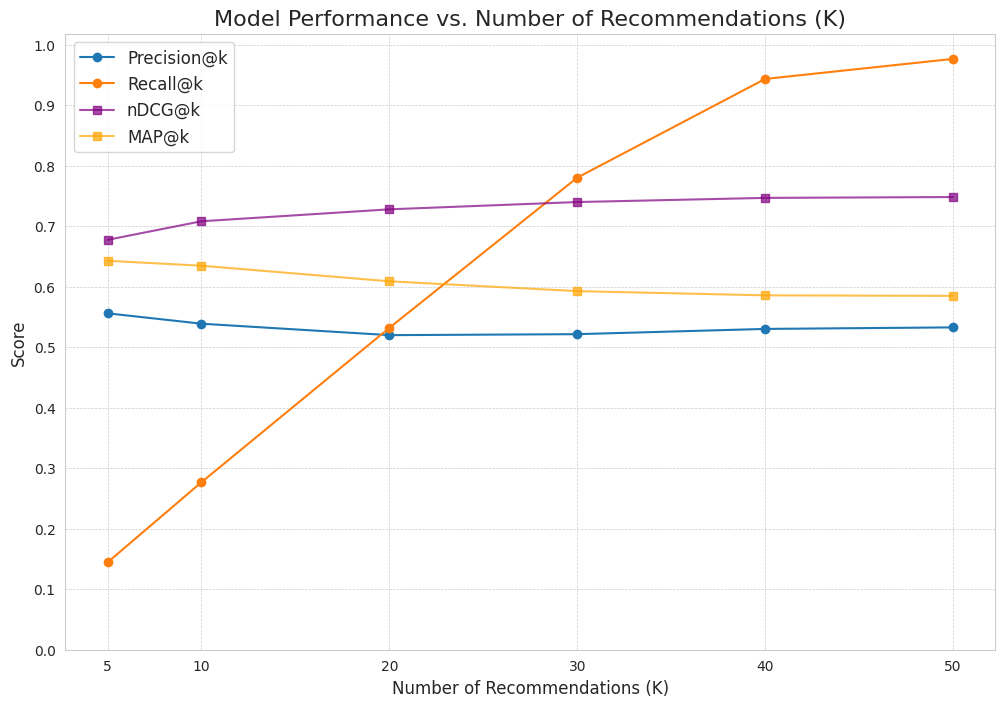

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Plot all metrics vs. K
plt.plot(results_df['k'], results_df['precision'], 'o-', label='Precision@k')
plt.plot(results_df['k'], results_df['recall'], 'o-', label='Recall@k')
plt.plot(results_df['k'], results_df['ndcg'], 's-', label='nDCG@k', color='purple', alpha=0.7)
plt.plot(results_df['k'], results_df['map'], 's-', label='MAP@k', color='orange', alpha=0.7)


plt.title('Model Performance vs. Number of Recommendations (K)', fontsize=16)
plt.xlabel('Number of Recommendations (K)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(k_values)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()